In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classes.geography_processing import Geoprocessing
from classes.model import Model
from classes.scenario import Scenario

# Turn off all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Proportion of treated patients that are LVO
prop_lvo = 0.30

## Base case

MSU provided from comprehensive stroke centres (thrombectomy centres)

In [3]:
# Set up scenario
scenario = Scenario({
    'name': 1,
    'limit_to_england' : True
})

# Process and save geographic data (only needed when hospital data changes)
geo = Geoprocessing(limit_to_england=True); geo.run()

# Set up model
model = Model(
    scenario=scenario,
    geodata=pd.read_csv('processed_data/processed_data.csv'))

# Run model
model.run()

# Get utilities
lsoa_drip_ship_utility = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility'] * (1 - prop_lvo)))

# Get the weighted average of lsoa_drip_ship_utility 
average_utility_drip_ship = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility) / np.sum(model.full_results['Admissions'])

lsoa_drip_ship_utility_shift = (
    (model.full_results['lvo_drip_ship_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_drip_ship_ivt_utility_shift'] * (1 - prop_lvo)))

lsoa_msu_utility_shift = (
    (model.full_results['lvo_msu_ivt_mt_utility_shift'] * prop_lvo) + 
    (model.full_results['nlvo_msu_ivt_utility_shift'] * (1 - prop_lvo)))

# Get the maximum of MSU and drip and ship
best_utility_shift = np.maximum(lsoa_msu_utility_shift, lsoa_drip_ship_utility_shift)

# Get the weighted average of lsoa_drip_ship_utility shift 
average_utility_drip_ship_shift = np.sum(
    model.full_results['Admissions'] * lsoa_drip_ship_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the average utility weighted by model.full_results['Admissions']
average_utility_shift = np.sum(model.full_results['Admissions'] * best_utility_shift) / np.sum(model.full_results['Admissions'])

# Get the advantage of MSU over drip and ship
advantage = average_utility_shift - average_utility_drip_ship_shift

In [4]:
untreated_utility = (average_utility_drip_ship - average_utility_drip_ship_shift)
print(f'Average untreated utility: {untreated_utility:0.3f}')
print(f'Average utility improvement for drip and ship: {average_utility_drip_ship_shift:0.3f}')
print(f'Average utility advantage for MSU over drip and ship: {advantage:0.3f}')


Average untreated utility: 0.520
Average utility improvement for drip and ship: 0.086
Average utility advantage for MSU over drip and ship: 0.022


## Load previous results

In [5]:
greedy_results = pd.read_csv('output/msu_advantages_greedy.csv')
greedy_results_csc = pd.read_csv('output/msu_advantages_greedy_csc.csv')
greedy_results.head()

,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,MSU advantage
0,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,...,13.4,534829,181798,-0.058133,51.519018,1,1,Royal London,NaN,0.005759
1,M68HD,1,1,1,England,Manchester,Lancashire & S.Cumbria SCN,Salford Royal NHS Foundation Trust,Salford Royal Hospital,1848,...,6.5,378637,399030,-2.323424,53.487545,1,1,Salford,NaN,0.009504
2,B714HJ,1,0,1,England,West Midlands SCN,Sandwell and West Birmingham Hospitals NHS Trust,"Sandwell District Hospital, West Bromwich",Sandwell District Hospital,741,...,6.7,400919,292165,-1.987884,52.527357,0,0,West Bromwich,NaN,0.012298
3,DN25LT,1,0,1,England,Yorkshire and The Humber SCN,Doncaster and Bassetlaw Hospitals NHS Foundati...,Doncaster Royal Infirmary,Doncaster Royal Infirmary,694,...,9.5,459143,404157,-1.109226,53.530751,0,0,Doncaster,NaN,0.013991
4,DH15TW,1,0,1,England,North of England SCN,County Durham and Darlington NHS Foundation Trust,University Hospital of North Durham,University Hospital of North Durham,961,...,9.8,426217,543809,-1.593834,54.788497,0,0,North Durham,NaN,0.015386


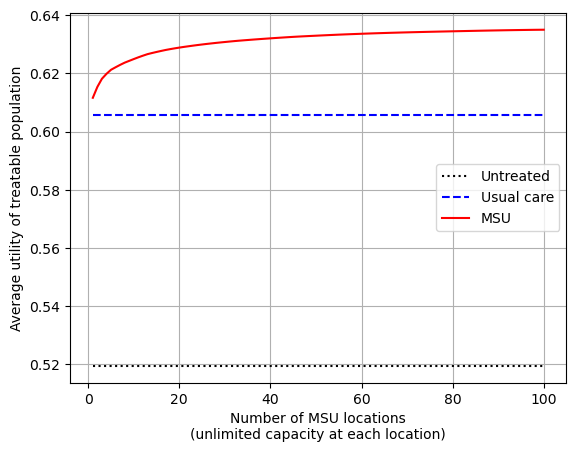

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(greedy_results)) + 1
y = greedy_results['MSU advantage'] + untreated_utility + average_utility_drip_ship_shift
untreated = np.repeat(untreated_utility, len(y))
drip_ship = np.repeat(untreated_utility + average_utility_drip_ship_shift, len(y))
ax.plot(x, untreated, c='k', linestyle=':', label='Untreated')
ax.plot(x, drip_ship, c='b', linestyle='dashed', label='Usual care')
ax.plot(x, y, '-', c='r', label = 'MSU')
ax.set_xlabel('Number of MSU locations\n(unlimited capacity at each location)')
ax.set_ylabel('Average utility of treatable population')
#ax.set_ylim(0.48, 0.62)
ax.grid()
# Put legend below x axis
ax.legend()
plt.savefig('greedy.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

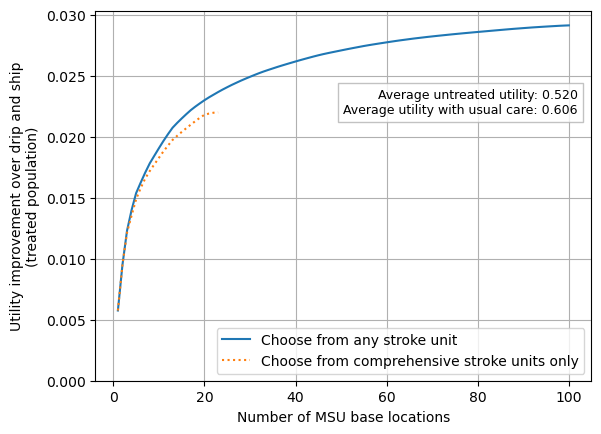

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(greedy_results)) + 1
y = greedy_results['MSU advantage']
x2 = np.arange(len(greedy_results_csc)) + 1
y2 = greedy_results_csc['MSU advantage']
ax.plot(x, y, '-', label = 'Choose from any stroke unit')
ax.plot(x2, y2, ':', label = 'Choose from comprehensive stroke units only')
ax.set_xlabel('Number of MSU base locations')
ax.set_ylabel('Utility improvement over drip and ship\n(treated population)')
ax.set_ylim(0)
ax.grid()

txt = f'Average untreated utility: {untreated_utility:0.3f}' + '\n' + \
    f'Average utility with usual care: {average_utility_drip_ship:0.3f}'

plt.legend(loc = 'lower right')
plt.text(102, 0.024, txt, fontsize=9, color='black', ha='right', va='top', wrap=True, 
         bbox=dict(facecolor='white', edgecolor='0.7', alpha=0.8))
plt.savefig('output/msu_advantages_greedy.png', dpi=300,bbox_inches='tight', pad_inches=0.1)

plt.show()
